In [1]:
from calibration import *

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research', group='iserc-1', project='main')

In [153]:
"""
Object to calibrate pulse of backend and qubit of interest.
"""

# Importing required python packages
from warnings import warn
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Importing standard Qiskit libraries
from qiskit import IBMQ, execute, pulse
from qiskit.providers.ibmq import IBMQBackend
from qiskit.pulse import DriveChannel, Schedule, Play
from qiskit.pulse import library as pulse_lib
from qiskit.pulse.library import Waveform, Gaussian
from qiskit.tools.monitor import job_monitor
from qiskit.providers.exceptions import QiskitBackendNotFoundError, BackendConfigurationError

# Loading your IBM Q account(s)
#IBMQ.load_account()
#provider = IBMQ.get_provider()


class PulseCalibration():
    """Creates an object that is used for pulse calibration.

    Args:
        backend (IBMQBackend) : The IBMQBackend for which pulse calibration needs to be done.
        qubit (int) : The qubit for which the pulse calibration is done.
        qubit_freq_ground (float) : Custom frequency for 0->1 transition.
        qubit_freq_excited (float) : Custom frequency for 1->2 transition.
        pi_amp_ground (float) : Custom pi amplitude for 0->1 transition.
                                The value should be between 0 and 1.
        pi_amp_excited (float) : Custom pi amplitude for 1->2 transition.
                                 The value should be between 0 and 1.
        pulse_dur (int) : The duration of the pi pulse to be used for calibration.
        pulse_sigma (int) : The standard deviation of the pi pulse to be used for calibration.

    """

    def __init__(self, backend, qubit, qubit_freq_ground=None, qubit_freq_excited=None,
                 pi_amp_ground=None, pi_amp_excited=None, pulse_dur=None, pulse_sigma=None):
        # pylint: disable=too-many-locals
        # pylint: disable=too-many-arguments
        if not isinstance(backend, IBMQBackend):
            raise QiskitBackendNotFoundError("Provided backend not available." +
                                             "Please provide backend after obtaining from IBMQ.")
        self._backend = backend
        self._back_config = backend.configuration()
        if qubit >= self._back_config.n_qubits:
            raise BackendConfigurationError(f"Qubit {qubit} not present in the provided backend.")
        self._qubit = qubit
        self._back_defaults = backend.defaults()
        self._qubit_anharmonicity = backend.properties().qubit_property(self._qubit)['anharmonicity'][0]
        self._dt = self._back_config.dt
        self._qubit_freq = self._back_defaults.qubit_freq_est[self._qubit]
        self._inst_sched_map = self._back_defaults.instruction_schedule_map
        self._drive_chan = DriveChannel(qubit)
        if pulse_sigma:
            self._pulse_sigma = pulse_sigma
        else:
            if self._backend.name() == 'ibmq_armonk':
                self._pulse_sigma = 80
            else:
                self._pulse_sigma = 40
        if pulse_dur:
            self._pulse_duration = pulse_dur
        else:
            self._pulse_duration = (4*self._pulse_sigma)-((4*self._pulse_sigma) % 16)
        self._qubit_freq_ground = qubit_freq_ground
        self._qubit_freq_excited = qubit_freq_excited
        self._pi_amp_ground = pi_amp_ground
        self._pi_amp_excited = pi_amp_excited
        self._state_discriminator_012 = None
        # Find out which measurement map index is needed for this qubit
        meas_map_idx = None
        for i, measure_group in enumerate(self._back_config.meas_map):
            if qubit in measure_group:
                meas_map_idx = i
                break
        assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
        # The measurement pulse for measuring the qubit of interest.
        self._measure = self._inst_sched_map.get('measure',
                                                 qubits=self._back_config.meas_map[meas_map_idx])

    def create_cal_circuit(self, amp):
        """Constructs and returns a schedule containing Gaussian pulse with amplitude as 'amp',
           sigma as 'pulse_sigma' and duration as 'pulse_duration'."""
        sched = Schedule()
        sched += Play(Gaussian(duration=self._pulse_duration, sigma=self._pulse_sigma,
                               amp=amp), self._drive_chan)
        sched += self._measure << sched.duration
        return sched

    def create_cal_circuit_excited(self, base_pulse, freq):
        """ Constructs and returns a schedule containing a pi pulse for 0->1 transition followed by
            a sidebanded pulse which corresponds to applying 'base_pulse' at frequency 'freq'."""
        sched = Schedule()
        sched += Play(Gaussian(duration=self._pulse_duration, sigma=self._pulse_sigma,
                               amp=self._pi_amp_ground), self._drive_chan)
        sched += Play(self.apply_sideband(base_pulse, freq), self._drive_chan)
        sched += self._measure << sched.duration
        return sched

    @staticmethod
    def _fit_function(x_values, y_values, function, init_params):
        """ A function fitter. Returns the fit parameters of 'function'."""
        fitparams, _ = curve_fit(function, x_values, y_values, init_params)
        y_fit = function(x_values, *fitparams)
        return fitparams, y_fit

    @staticmethod
    def _baseline_remove(values):
        """Centering data around zero."""
        return np.array(values) - np.mean(values)

    def apply_sideband(self, pulse, frequency):
        """Apply a sine sideband to 'pulse' at frequency 'freq'.
        Args:
            pulse (Waveform): The pulse to which sidebanding is to be applied.
            frequency (float): LO frequency at which the pulse is to be applied.

        Returns:
            Waveform: The sidebanded pulse.
        """
        t_samples = np.linspace(0, self._dt*self._pulse_duration, self._pulse_duration)
        sine_pulse = np.sin(2*np.pi*(frequency-self._qubit_freq_ground)*t_samples)
        sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse),
                                  name='sideband_pulse')
        return sideband_pulse

    def get_job_data(self, job, average):
        """Retrieve data from a job that has already run.
        Args:
            job (Job): The job whose data you want.
            average (bool): If True, gets the data assuming data is an average.
                            If False, gets the data assuming it is for single shots.
        Return:
            list: List containing job result data.
        """
        scale_factor = 1e-14
        job_results = job.result(timeout=120)  # timeout parameter set to 120 s
        result_data = []
        for i in range(len(job_results.results)):
            if average:  # get avg data
                result_data.append(job_results.get_memory(i)[self._qubit]*scale_factor)
            else:  # get single data
                result_data.append(job_results.get_memory(i)[:, self._qubit]*scale_factor)
        return result_data

    # Prints out relative maxima frequencies in output_data; height gives lower bound (abs val)
    @staticmethod
    def _rel_maxima(freqs, output_data, height, distance):
        """Prints out relative maxima frequencies in output_data (can see peaks);
           height gives upper bound (abs val). Be sure to set the height properly or
           the peak will be ignored!
        Args:
            freqs (list): frequency list
            output_data (list): list of resulting signals
            height (float): upper bound (abs val) on a peak
            width (float): 
        Returns:
            list: List containing relative maxima frequencies
        """
        peaks, _ = find_peaks(x=output_data, height=height, distance=distance)
        return freqs[peaks]

    def find_freq_ground(self, verbose=False, visual=False):
        """Sets and returns the calibrated frequency corresponding to 0->1 transition."""
        # pylint: disable=too-many-locals
        sched_list = [self.create_cal_circuit(0.5)]*75
        freq_list = np.linspace(self._qubit_freq-(45*1e+6), self._qubit_freq+(45*1e+6), 75)
        sweep_job = execute(sched_list, backend=self._backend, meas_level=1, meas_return='avg',
                            shots=1024, schedule_los = [{self._drive_chan: freq} for freq in freq_list])
        jid = sweep_job.job_id()
        
        if verbose:
            print("Executing the Frequency sweep job for 0->1 transition.")
            print('Job Id : ', jid)
#             job_monitor(sweep_job)
        sweep_job = self._backend.retrieve_job(jid)
        sweep_result = sweep_job.result()
        sweep_values = []
        for i in range(len(sweep_result.results)):
            # Get the results from the ith experiment
            res = sweep_result.get_memory(i)*1e-14
            # Get the results for `qubit` from this experiment
            sweep_values.append(res[self._qubit])

        freq_list_GHz = freq_list/1e+9
        if visual:
            print("The frequency-signal plot for frequency sweep: ")
            plt.scatter(freq_list_GHz, np.real(sweep_values), color='black')
            plt.xlim([min(freq_list_GHz), max(freq_list_GHz)])
            plt.xlabel("Frequency [GHz]")
            plt.ylabel("Measured Signal [a.u.]")
            plt.show()

#         def find_init_params(freq_list, res_values):
#             hmin_index = np.where(res_values==min(res_values[:len(freq_list)//2]))[0][0]
#             hmax_index = np.where(res_values==max(res_values[:len(freq_list)//2]))[0][0]
#             if hmin_index < hmax_index:
#                 est_baseline = min(res_values)
#                 est_slope = (res_values[hmax_index] - res_values[hmin_index])/(freq_list[hmax_index] - freq_list[hmin_index])
#             else:
#                 est_baseline = max(res_values)
#                 est_slope = (res_values[hmin_index] - res_values[hmax_index])/(freq_list[hmin_index] - freq_list[hmax_index])
#             return [est_slope, self._qubit_freq/1e9, 1, est_baseline]

        def find_init_params_gauss(freq_list, res_values):
            hmin_index = np.where(res_values==min(res_values[:len(freq_list)//2]))[0][0]
            hmax_index = np.where(res_values==max(res_values[:len(freq_list)//2]))[0][0]
            mean_est = freq_list[hmax_index]
            var_est = np.abs(freq_list[hmax_index]-freq_list[hmin_index])/2
            scale_est = max(res_values)-min(res_values)
            shift_est = min(res_values)
            return [mean_est, var_est, scale_est, shift_est]

        def gauss(x, mean, var, scale, shift):
            return (scale*(1/var*np.sqrt(2*np.pi))*np.exp(-(1/2)*(((x-mean)/var)**2)))+shift
        
        def lorentzian(xval, scale, q_freq, hwhm, shift):
            return (scale / np.pi) * (hwhm / ((xval - q_freq)**2 + hwhm**2)) + shift
        # do fit in Hz
        
        init_params = find_init_params_gauss(freq_list_GHz, np.real(sweep_values))
#         init_params = find_init_params(freq_list_GHz, np.real(sweep_values))
        print('ground freq init params : ', init_params)
        # Obtain the optimal paramters that fit the result data.
#         fit_params, y_fit = self._fit_function(freq_list_GHz,
#                                                np.real(sweep_values),
#                                                lorentzian,
#                                                init_params  # init parameters for curve_fit
#                                                )
        fit_params, y_fit = self._fit_function(freq_list_GHz,
                                               np.real(sweep_values),
                                               gauss,
                                               init_params  # init parameters for curve_fit
                                               )
        if visual:
            print("The frequency-signal plot for frequency sweep: ")
            plt.scatter(freq_list_GHz, np.real(sweep_values), color='black')
            plt.plot(freq_list_GHz, y_fit, color='red')
            plt.xlim([min(freq_list_GHz), max(freq_list_GHz)])
            plt.xlabel("Frequency [GHz]")
            plt.ylabel("Measured Signal [a.u.]")
            plt.show()
        qubit_freq_new, _, _, _ = fit_params
        self._qubit_freq_ground = qubit_freq_new*1e9
        if verbose:
            print(f"The calibrate frequency for the 0->1 transition is {self._qubit_freq_ground}")
        return [self._qubit_freq_ground, freq_list_GHz, sweep_values]

    def find_pi_amp_ground(self, verbose=False, visual=False):
        """Sets and returns the amplitude of the pi pulse corresponding to 0->1 transition."""
        # pylint: disable=too-many-locals
        if not self._qubit_freq_ground:
            warn("ground_qubit_freq not computed yet and custom qubit freq not provided." +
                 "Computing ground_qubit_freq now.")
            self._qubit_freq_ground = self.find_freq_ground(verbose, visual)
        amp_list = np.linspace(0, 1, 75)
        rabi_sched_list = [self.create_cal_circuit(amp) for amp in amp_list]
        rabi_list_len = len(rabi_sched_list)
        rabi_job = execute(rabi_sched_list,backend=self._backend, meas_level=1, meas_return='avg', 
                           shots=1024, schedule_los=[{self._drive_chan: self._qubit_freq_ground}]*len(rabi_sched_list))
        jid = rabi_job.job_id()
        if verbose:
            print("Executing the rabi oscillation job to get Pi pulse for 0->1 transition.")
            print('Job Id : ', jid)
#             job_monitor(rabi_job)
        rabi_job = self._backend.retrieve_job(jid)
        rabi_results = rabi_job.result()
        scale_factor = 1e-14
        rabi_values = []
        for i in range(75):
            # Get the results for `qubit` from the ith experiment
            rabi_values.append(rabi_results.get_memory(i)[self._qubit]*scale_factor)

        rabi_values = np.real(self._baseline_remove(rabi_values))

        def find_init_params_amp(amp_list, rabi_values):
            min_index = np.where(rabi_values==min(rabi_values))[0][0]
            max_index = np.where(rabi_values==max(rabi_values))[0][0]
            scale_est = (max(rabi_values) - min(rabi_values))/2
            shift_est = (max(rabi_values) + min(rabi_values))/2
            shift_est = np.mean(rabi_values)
            period_est = 0.5
            if ((max(rabi_values)-rabi_values[0])/(2*scale_est)) < 0.5:
                phi_est = np.pi/2
            else:
                phi_est = -np.pi/2
            return [scale_est, shift_est, period_est, phi_est]

        # Obtain the optimal paramters that fit the result data.
        init_params = find_init_params_amp(amp_list,rabi_values)
        fit_params, y_fit = self._fit_function(amp_list,
                                               rabi_values,
                                               lambda x, A, B, drive_period, phi: (A*np.sin(2*np.pi*x/drive_period - phi) + B),
                                               init_params)
        drive_period = fit_params[2]
        self._pi_amp_ground = drive_period/2
        if verbose:
            print(f"The Pi amplitude of 0->1 transition is {self._pi_amp_ground}.")
        if visual:
            print("The amplitude-signal plot for rabi oscillation for 0->1 transition.")
            plt.figure()
            plt.scatter(amp_list, rabi_values, color='black')
            plt.plot(amp_list, y_fit, color='red')
            plt.axvline(drive_period/2, color='red', linestyle='--')
            plt.axvline(drive_period, color='red', linestyle='--')
            plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2, 0),
                         arrowprops=dict(arrowstyle="<->", color='red'))
            #plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

            plt.xlabel("Drive amp [a.u.]", fontsize=15)
            plt.ylabel("Measured signal [a.u.]", fontsize=15)
            plt.show()

        return [self._pi_amp_ground, amp_list, rabi_values]

    def find_freq_excited(self, verbose=False, visual=False):
        """Sets and returns the frequency corresponding to 1->2 transition."""
        # pylint: disable=too-many-locals
        if not self._qubit_freq_ground:
            raise ValueError("The qubit_freq_ground is not determined. Please determine" +
                             "qubit_freq_ground first.")
        if not self._pi_amp_ground:
            raise ValueError("The pi_amp_ground is not determined.\
                               Please determine pi_amp_ground first.")
        base_pulse = pulse_lib.gaussian(duration=self._pulse_duration,
                                        sigma=self._pulse_sigma, amp=0.3)
        sched_list = []
        # Here we assume that the anharmocity is about 8% for all qubits.
        excited_freq_list = self._qubit_freq_ground + self._qubit_anharmonicity + np.linspace(-30*1e+6, 30*1e+6, 75)
        for freq in excited_freq_list:
            sched_list.append(self.create_cal_circuit_excited(base_pulse, freq))
        excited_sweep_job = execute(sched_list, backend=self._backend, 
                                    meas_level=1, meas_return='avg', shots=1024,
                                    schedule_los=[{self._drive_chan: self._qubit_freq_ground}]*len(excited_freq_list)
                                    )
        jid = excited_sweep_job.job_id()
        excited_freq_list_GHz = excited_freq_list/1e+9
        if verbose:
            print("Executing the Frequency sweep job for 1->2 transition.")
            print('Job Id : ', jid)
#             job_monitor(excited_sweep_job)
        excited_sweep_job = self._backend.retrieve_job(jid)
        excited_sweep_data = self.get_job_data(excited_sweep_job, average=True)
        if visual:
            print("The frequency-signal plot of frequency sweep for 1->2 transition.")
            # Note: we are only plotting the real part of the signal
            plt.scatter(excited_freq_list_GHz, excited_sweep_data, color='black')
            plt.xlim([min(excited_freq_list_GHz), max(excited_freq_list_GHz)])
            plt.xlabel("Frequency [GHz]", fontsize=15)
            plt.ylabel("Measured Signal [a.u.]", fontsize=15)
            plt.title("1->2 Frequency Sweep", fontsize=15)
            plt.show()

        def find_init_params_gauss(freq_list, res_values):
            hmin_index = np.where(res_values==min(res_values[:len(freq_list)//2]))[0][0]
            hmax_index = np.where(res_values==max(res_values[:len(freq_list)//2]))[0][0]
            mean_est = freq_list[hmax_index]
            var_est = np.abs(freq_list[hmax_index]-freq_list[hmin_index])/2
            scale_est = max(res_values)-min(res_values)
            shift_est = min(res_values)
            return [mean_est, var_est, scale_est, shift_est]

        def gauss(x, mean, var, scale, shift):
            return (scale*(1/var*np.sqrt(2*np.pi))*np.exp(-(1/2)*(((x-mean)/var)**2)))+shift
        
        def lorentzian(xval, scale, q_freq, hwhm, shift):
            return (scale / np.pi) * (hwhm / ((xval - q_freq)**2 + hwhm**2)) + shift
        # do fit in Hz
        
#         init_params = find_init_params(excited_freq_list_GHz, np.real(excited_sweep_data))
        init_params = find_init_params_gauss(excited_freq_list_GHz, np.real(excited_sweep_data))
        print("Init params : ", init_params)
        excited_sweep_fit_params, excited_sweep_y_fit = self._fit_function(excited_freq_list_GHz,
                                                   excited_sweep_data,
                                                   gauss,
                                                   init_params
                                                   )
        if visual:
            print("The frequency-signal plot of frequency sweep for 1->2 transition.")
            # Note: we are only plotting the real part of the signal
            plt.scatter(excited_freq_list/1e+9, excited_sweep_data, color='black')
            plt.plot(excited_freq_list/1e+9, excited_sweep_y_fit, color='red')
            plt.xlim([min(excited_freq_list/1e+9), max(excited_freq_list/1e+9)])
            plt.xlabel("Frequency [GHz]", fontsize=15)
            plt.ylabel("Measured Signal [a.u.]", fontsize=15)
            plt.title("1->2 Frequency Sweep", fontsize=15)
            plt.show()
        qubit_freq_12, _, _, _ = excited_sweep_fit_params
        self._qubit_freq_excited = qubit_freq_12*1e+9
        if verbose:
            print(f"The calibrated frequency for the 1->2 transition\
                     is {self._qubit_freq_excited}.")
        return [self._qubit_freq_excited, excited_freq_list, excited_sweep_data]

    def find_pi_amp_excited(self, verbose=False, visual=False):
        """Sets and returns the amplitude of the pi pulse corresponding to 1->2 transition."""
        if not self._qubit_freq_excited:
            warn("ground_qubit_freq not computed yet and custom qubit freq not provided." +
                 "Computing ground_qubit_freq now.")
            self._qubit_freq_ground = self.find_freq_excited(verbose, visual)
        amp_list = np.linspace(0, 1.0, 75)
        rabi_sched_list = []
        for amp in amp_list:
            base_pulse = pulse_lib.gaussian(duration=self._pulse_duration,
                                            sigma=self._pulse_sigma, amp=amp)
            rabi_sched_list.append(self.create_cal_circuit_excited(base_pulse,
                                   self._qubit_freq_excited))
        rabi_job = execute(rabi_sched_list, backend=self._backend,
                            meas_level=1, meas_return='avg', shots=1024,
                            schedule_los=[{self._drive_chan: self._qubit_freq_ground}]*75
                            )
        jid = rabi_job.job_id()
        if verbose:
            print("Executing the rabi oscillation job for 1->2 transition.")
            print('Job Id : ', jid)
#             job_monitor(rabi_job)
        rabi_job = self._backend.retrieve_job(jid)
        rabi_data = self.get_job_data(rabi_job, average=True)
        rabi_data = np.real(self._baseline_remove(rabi_data))
        if visual:
            print("The amplitude-signal plot of rabi oscillation for 1->2 transition.")
            plt.figure()
            plt.scatter(amp_list, rabi_data, color='black')
            plt.xlabel("Drive amp [a.u.]", fontsize=15)
            plt.ylabel("Measured signal [a.u.]", fontsize=15)
            plt.title('Rabi Experiment (1->2)', fontsize=20)
            plt.show()
        
        def find_init_params_amp(amp_list, rabi_values):
            min_index = np.where(rabi_values==min(rabi_values))[0][0]
            max_index = np.where(rabi_values==max(rabi_values))[0][0]
            scale_est = (max(rabi_values) - min(rabi_values))/2
            shift_est = (max(rabi_values) + min(rabi_values))/2
            shift_est = np.mean(rabi_values)
            period_est = 0.5
            if ((max(rabi_values)-rabi_values[0])/(2*scale_est)) < 0.5:
                phi_est = np.pi/2
            else:
                phi_est = -np.pi/2
            return [scale_est, shift_est, period_est, phi_est]

        init_params = find_init_params_amp(amp_list, rabi_data)
        print('Init params for 01 amp : ', init_params)
        (rabi_fit_params,
         rabi_y_fit) = self._fit_function(amp_list,
                                          rabi_data,
                                          lambda x, A, B, drive_period, phi: (A*np.sin(2*np.pi*x/drive_period - phi) + B),
                                          init_params)
        drive_period_excited = rabi_fit_params[2]
        pi_amp_excited = (drive_period_excited/2/np.pi) * (np.pi+rabi_fit_params[3])
        self._pi_amp_excited = pi_amp_excited
        if visual:
            print("The amplitude-signal plot of rabi oscillation for 1->2 transition.")
            plt.figure()
            plt.scatter(amp_list, rabi_data, color='black')
            plt.plot(amp_list, rabi_y_fit, color='red')
            # account for phi in computing pi amp

            plt.axvline(self._pi_amp_excited, color='red', linestyle='--')
            plt.axvline(self._pi_amp_excited+drive_period_excited/2, color='red', linestyle='--')
            plt.annotate("", xy=(self._pi_amp_excited+drive_period_excited/2, 0),
                         xytext=(self._pi_amp_excited, 0),
                         arrowprops=dict(arrowstyle="<->", color='red'))
            #plt.annotate("$\\pi$", xy=(self._pi_amp_excited-0.03, 0.1), color='red')

            plt.xlabel("Drive amp [a.u.]", fontsize=15)
            plt.ylabel("Measured signal [a.u.]", fontsize=15)
            plt.title('Rabi Experiment (1->2)', fontsize=20)
            plt.show()
        return [self._pi_amp_excited, amp_list, rabi_data]

    def get_pi_pulse_ground(self):
        """Returns a pi pulse of the 0->1 transition."""
        pulse = pulse_lib.gaussian(duration=self._pulse_duration,
                                   sigma=self._pulse_sigma, amp=self._pi_amp_ground)
        return pulse

    def get_pi_pulse_excited(self):
        """Returns a pi pulse of the 1->2 transition."""
        pulse = pulse_lib.gaussian(duration=self._pulse_duration, sigma=self._pulse_sigma,
                                   amp=self._pi_amp_excited)
        excited_pulse = self.apply_sideband(pulse, self._qubit_freq_excited)
        return excited_pulse

    def get_x90_pulse_ground(self):
        """Returns a pi/2 pulse of the 0->1 transition."""
        pulse = pulse_lib.gaussian(duration=self._pulse_duration,
                                   sigma=self._pulse_sigma, amp=self._pi_amp_ground/2)
        return pulse
    def get_x90_pulse_excited(self):
        """Returns a pi/2 pulse of the 1->2 transition."""
        pulse = pulse_lib.gaussian(duration=self._pulse_duration, sigma=self._pulse_sigma,
                                   amp=self._pi_amp_excited/2)
        excited_pulse = self.apply_sideband(pulse, self._qubit_freq_excited)
        return excited_pulse

    def get_zero_sched(self):
        """Returns a schedule that performs only a measurement."""
        zero_sched = Schedule()
        zero_sched += self._measure
        return zero_sched

    def get_one_sched(self):
        """Returns a schedule that creates a |1> state from |0> by applying
           a pi pulse of 0->1 transition and performs a measurement."""
        one_sched = Schedule()
        one_sched += Play(self.get_pi_pulse_ground(), self._drive_chan)
        one_sched += self._measure << one_sched.duration
        return one_sched

    def get_two_sched(self):
        """Returns a schedule that creates a |2> state from |0> by applying
           a pi pulse of 0->1 transition followed by applying a pi pulse
           of 1->2 transition and performs a measurement."""
        two_sched = Schedule()
        two_sched += Play(self.get_pi_pulse_ground(), self._drive_chan)
        two_sched += Play(self.get_pi_pulse_excited(), self._drive_chan)
        two_sched += self._measure << two_sched.duration
        return two_sched

    @staticmethod
    def _create_iq_plot(zero_data, one_data, two_data):
        """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
        as arguments."""
        # zero data plotted in blue
        plt.scatter(np.real(zero_data), np.imag(zero_data),
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
        # one data plotted in red
        plt.scatter(np.real(one_data), np.imag(one_data),
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
        # two data plotted in green
        plt.scatter(np.real(two_data), np.imag(two_data),
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

        x_min = np.min(np.append(np.real(zero_data), np.append(np.real(one_data),
                       np.real(two_data))))-5
        x_max = np.max(np.append(np.real(zero_data), np.append(np.real(one_data),
                       np.real(two_data))))+5
        y_min = np.min(np.append(np.imag(zero_data), np.append(np.imag(one_data),
                       np.imag(two_data))))-5
        y_max = np.max(np.append(np.imag(zero_data), np.append(np.imag(one_data),
                       np.imag(two_data))))+5

        # Plot a large dot for the average result of the 0, 1 and 2 states.
        mean_zero = np.mean(zero_data)  # takes mean of both real and imaginary parts
        mean_one = np.mean(one_data)
        mean_two = np.mean(two_data)
        plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                    s=200, cmap='viridis', c='black', alpha=1.0)
        plt.scatter(np.real(mean_one), np.imag(mean_one),
                    s=200, cmap='viridis', c='black', alpha=1.0)
        plt.scatter(np.real(mean_two), np.imag(mean_two),
                    s=200, cmap='viridis', c='black', alpha=1.0)

#         plt.xlim(x_min, x_max)
#         plt.ylim(y_min, y_max)
        plt.legend()
        plt.ylabel('I [a.u.]', fontsize=15)
        plt.xlabel('Q [a.u.]', fontsize=15)
        plt.title("0-1-2 discrimination", fontsize=15)
        return x_min, x_max, y_min, y_max

    @staticmethod
    def reshape_complex_vec(vec):
        """Take in complex vector vec and return 2d array w/ real, imag entries.
           This is needed for the learning.
        Args:
            vec (list): complex vector of data
        Returns:
            list: vector w/ entries given by (real(vec], imag(vec))
        """
        length = len(vec)
        vec_reshaped = np.zeros((length, 2))
        for i, item in enumerate(vec):
            vec_reshaped[i] = [np.real(item), np.imag(item)]
        return vec_reshaped

    def find_three_level_discriminator(self, verbose=False, visual=False):
        """Returns a discriminator for discriminating 0-1-2 states."""
        # pylint: disable=too-many-locals
        zero_sched = self.get_zero_sched()
        one_sched = self.get_one_sched()
        two_sched = self.get_two_sched()
        iq_job = execute([zero_sched, one_sched, two_sched], backend=self._backend,
                          meas_level=1, meas_return='single', shots=1024,
                          schedule_los=[{self._drive_chan: self._qubit_freq_ground}]*3
                          )
        jid = iq_job.job_id()
        if verbose:
            print('Job Id : ', jid)
#             job_monitor(iq_job)
        iq_job = self._backend.retrieve_job(jid)
        iq_data = self.get_job_data(iq_job, average=False)
        zero_data = iq_data[0]
        one_data = iq_data[1]
        two_data = iq_data[2]
        if visual:
            print("The discriminator plot for 0-1-2 discrimination.")
            x_min, x_max, y_min, y_max = self._create_iq_plot(zero_data, one_data, two_data)
        # Create IQ vector (split real, imag parts)
        zero_data_reshaped = self.reshape_complex_vec(zero_data)
        one_data_reshaped = self.reshape_complex_vec(one_data)
        two_data_reshaped = self.reshape_complex_vec(two_data)

        iq_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))

        # construct vector w/ 0's, 1's and 2's (for testing)
        state_012 = np.zeros(1024)  # shots gives number of experiments
        state_012 = np.concatenate((state_012, np.ones(1024)))
        state_012 = np.concatenate((state_012, 2*np.ones(1024)))

        # Shuffle and split data into training and test sets
        iq_012_train, iq_012_test, state_012_train, state_012_test = train_test_split(iq_data,
                                                                                      state_012,
                                                                                      test_size=0.5)
        classifier_lda_012 = LinearDiscriminantAnalysis()
        classifier_lda_012.fit(iq_012_train, state_012_train)
        score_012 = classifier_lda_012.score(iq_012_test, state_012_test)
        if verbose:
            print('The accuracy score of the discriminator is: ', score_012)
        self._state_discriminator_012 = classifier_lda_012
        if visual:
            self._separatrix_plot(classifier_lda_012, x_min, x_max, y_min, y_max, 1024)
        return self._state_discriminator_012

    @staticmethod
    def _separatrix_plot(lda, x_min, x_max, y_min, y_max, shots):
        """Returns a sepratrix plot for the classifier."""
        # pylint: disable=too-many-arguments
        num_x, num_y = shots, shots
        xvals, vals = np.meshgrid(np.linspace(x_min, x_max, num_x),
                                  np.linspace(y_min, y_max, num_y))
        predict_prob = lda.predict_proba(np.c_[xvals.ravel(), vals.ravel()])
        predict_prob = predict_prob[:, 1].reshape(xvals.shape)
        plt.contour(xvals, vals, predict_prob, [0.5], linewidths=2., colors='black')

    def get_qubit_freq_ground(self):
        """Returns the set 0->1 transition frequency."""
        return self._qubit_freq_ground

    def get_qubit_freq_excited(self):
        """Returns the set 1->2 transition frequency."""
        return self._qubit_freq_excited

    def get_pi_amp_ground(self):
        """Returns the set 0->1 transition pi pulse amplitude."""
        return self._pi_amp_ground

    def get_pi_amp_excited(self):
        """Returns the set 1->2 transition pi pulse amplitude."""
        return self._pi_amp_excited

    def get_three_level_discriminator(self):
        """Returns the set 0-1-2 state discriminator."""
        return self._state_discriminator_012

    def calibrate_all(self, verbose=False, visual=False):
        """Calibrates and sets both the ground and excited transition frequencies and
           corresponding pi pulse amplitudes. Also constructs a 0-1-2 state discriminator."""
        ground_freq = self.find_freq_ground(verbose, visual)
        ground_amp = self.find_pi_amp_ground(verbose, visual)
        excited_freq = self.find_freq_excited(verbose, visual)
        excited_amp = self.find_pi_amp_excited(verbose, visual)
        state_discriminator = self.find_three_level_discriminator(verbose, visual)
        return ground_freq, ground_amp, excited_freq, excited_amp, state_discriminator


In [172]:
anharmon = backend.properties().qubit_property(qubit)['anharmonicity'][0]
qu_freq = backend.properties().qubit_property(qubit)['frequency'][0]
print(qu_freq)
print(anharmon)
print(qu_freq+anharmon)

4822063151.22466
-339904808.0433307
4482158343.181329


In [154]:
# backend = provider.get_backend('ibmq_casablanca')
# backend = provider.get_backend('ibmq_jakarta')
backend = provider.get_backend('ibmq_rome')
qubit = 0

In [155]:
cal_object = PulseCalibration(backend, qubit)

In [156]:
visual = True
verbose = True

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Executing the Frequency sweep job for 0->1 transition.
Job Id :  60b500467ff60558caf0212f
The frequency-signal plot for frequency sweep: 


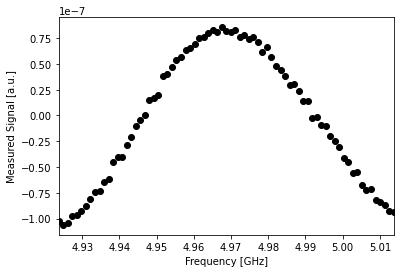

ground freq init params :  [4.967487683991133, 0.021283783783783594, 1.9166201e-07, -1.0613276e-07]
The frequency-signal plot for frequency sweep: 


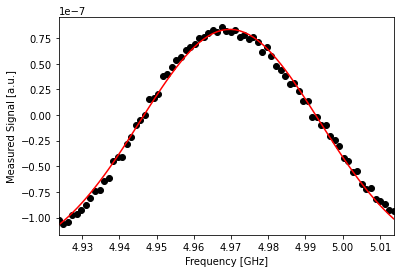

The calibrate frequency for the 0->1 transition is 4969674483.106029


In [157]:
ground_freq_list = cal_object.find_freq_ground(verbose, visual)

In [158]:
[ground_freq, freq_list, sweep_vals] = ground_freq_list

In [159]:
print(ground_freq)

4969674483.106029


/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Executing the rabi oscillation job to get Pi pulse for 0->1 transition.
Job Id :  60b500b04a088c9217c55eb3
The Pi amplitude of 0->1 transition is 0.17572474741481725.
The amplitude-signal plot for rabi oscillation for 0->1 transition.


/home/tharrma/research_qiskit/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


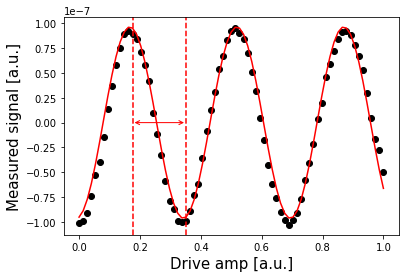

In [160]:
ground_amp_list = cal_object.find_pi_amp_ground(verbose, visual)

In [161]:
pi_amp_ground = ground_amp_list[0]
amp_list = ground_amp_list[1]
rabi_values = ground_amp_list[2]

In [162]:
print(ground_freq)
print(pi_amp_ground)

4969674483.106029
0.17572474741481725


/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Executing the Frequency sweep job for 1->2 transition.
Job Id :  60b5010932703c767a1a13c1
The frequency-signal plot of frequency sweep for 1->2 transition.


/home/tharrma/research_qiskit/lib/python3.7/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


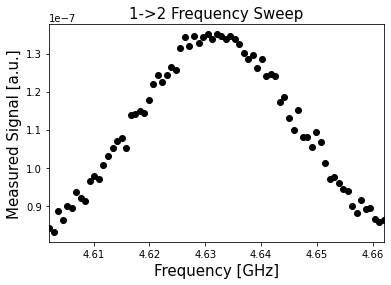

Init params :  [4.630425271371337, 0.01378378378378331, 5.194931e-08, 8.312541e-08]
The frequency-signal plot of frequency sweep for 1->2 transition.


/home/tharrma/research_qiskit/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


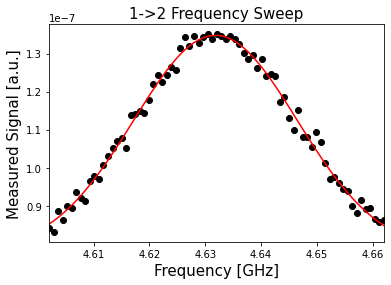

The calibrated frequency for the 1->2 transition                     is 4631841032.831609.


In [163]:
excited_list = cal_object.find_freq_excited(verbose, visual)

In [164]:
excited_freq = excited_list[0]
excited_freq_list = excited_list[1]
excited_sweep_data = excited_list[2]
excited_freq_list_GHz = excited_freq_list/1e+9

In [165]:
excited_freq

4631841032.831609

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Executing the rabi oscillation job for 1->2 transition.
Job Id :  60b501654a088c67a1c55eb9
The amplitude-signal plot of rabi oscillation for 1->2 transition.


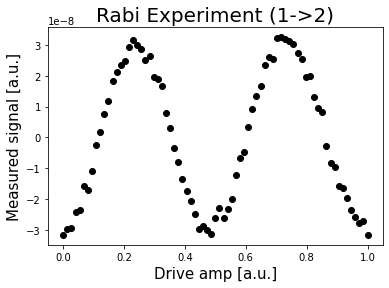

Init params for 01 amp :  [3.2052157500000004e-08, 2.4705127628250428e-24, 0.5, -1.5707963267948966]
The amplitude-signal plot of rabi oscillation for 1->2 transition.


/home/tharrma/research_qiskit/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


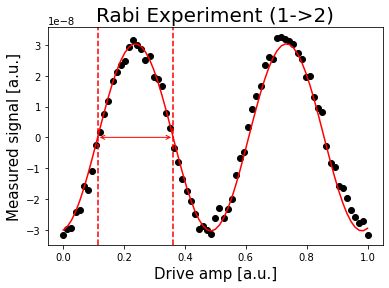

In [166]:
pi_amp_excited_list = cal_object.find_pi_amp_excited(verbose, visual)

In [167]:
[excited_amp, amp_list, rabi_data] = pi_amp_excited_list

In [168]:
pi_amp_excited = excited_amp

In [169]:
pi_amp_excited

0.11335415791231139

In [170]:
print(ground_freq)
print(pi_amp_ground)
print(excited_freq)
print(pi_amp_excited)

4969674483.106029
0.17572474741481725
4631841032.831609
0.11335415791231139


/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Job Id :  60b501ab4a088c8310c55ebd
The discriminator plot for 0-1-2 discrimination.
The accuracy score of the discriminator is:  0.7805989583333334


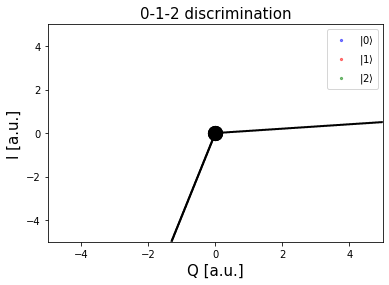

In [171]:
discrim = cal_object.find_three_level_discriminator(verbose, visual)

In [172]:
def create_iq_plot(zero_data, one_data, two_data):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    x_min = np.min(np.append(np.real(zero_data), np.append(np.real(one_data),
                   np.real(two_data))))-5
    x_max = np.max(np.append(np.real(zero_data), np.append(np.real(one_data),
                   np.real(two_data))))+5
    y_min = np.min(np.append(np.imag(zero_data), np.append(np.imag(one_data),
                   np.imag(two_data))))-5
    y_max = np.max(np.append(np.imag(zero_data), np.append(np.imag(one_data),
                   np.imag(two_data))))+5

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data)  # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=200, cmap='viridis', c='black', alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=200, cmap='viridis', c='black', alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=200, cmap='viridis', c='black', alpha=1.0)

#         plt.xlim(x_min, x_max)
#         plt.ylim(y_min, y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)
    return x_min, x_max, y_min, y_max

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries.
       This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i, item in enumerate(vec):
        vec_reshaped[i] = [np.real(item), np.imag(item)]
    return vec_reshaped

def separatrix_plot(lda, x_min, x_max, y_min, y_max, shots):
    """Returns a sepratrix plot for the classifier."""
    # pylint: disable=too-many-arguments
    num_x, num_y = shots, shots
    xvals, vals = np.meshgrid(np.linspace(x_min-4, x_max+4, num_x),
                              np.linspace(y_min-4, y_max+4, num_y))
    predict_prob = lda.predict_proba(np.c_[xvals.ravel(), vals.ravel()])
    predict_prob = predict_prob[:, 1].reshape(xvals.shape)
    plt.contour(xvals, vals, predict_prob, [0.5], linewidths=2., colors='black')

def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    scale_factor = 1e-14
    job_results = job.result(timeout=120)  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor)
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)
    return result_data

The discriminator plot for 0-1-2 discrimination.


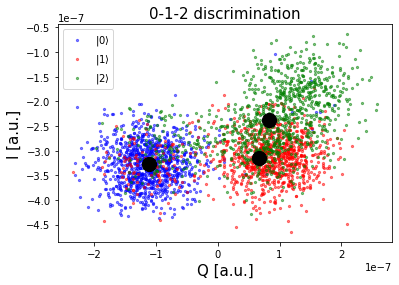

In [173]:
iq_job = backend.retrieve_job('60b501ab4a088c8310c55ebd')
iq_data = get_job_data(iq_job, average=False)
zero_data = iq_data[0]
one_data = iq_data[1]
two_data = iq_data[2]
if visual:
    print("The discriminator plot for 0-1-2 discrimination.")
    x_min, x_max, y_min, y_max = create_iq_plot(zero_data, one_data, two_data)

In [174]:
newcalobject = PulseCalibration(backend, qubit)

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Executing the Frequency sweep job for 0->1 transition.
Job Id :  60b502414e242734082cec0d
The frequency-signal plot for frequency sweep: 


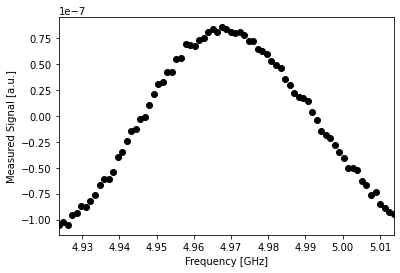

ground freq init params :  [4.967487683991133, 0.021891891891891557, 1.9054509e-07, -1.0517581e-07]
The frequency-signal plot for frequency sweep: 


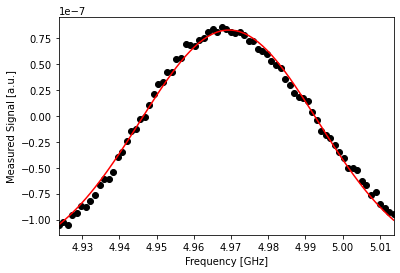

The calibrate frequency for the 0->1 transition is 4969452919.576077


/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Executing the rabi oscillation job to get Pi pulse for 0->1 transition.
Job Id :  60b5027dd3cf25c59845038c
The Pi amplitude of 0->1 transition is 0.17583344067254725.
The amplitude-signal plot for rabi oscillation for 0->1 transition.


/home/tharrma/research_qiskit/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


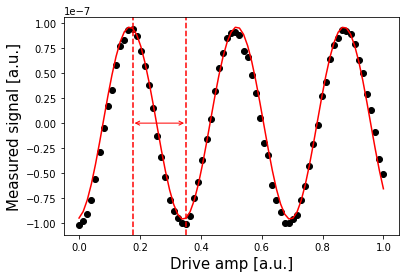

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Executing the Frequency sweep job for 1->2 transition.
Job Id :  60b502ba7ff6050763f02148
The frequency-signal plot of frequency sweep for 1->2 transition.


/home/tharrma/research_qiskit/lib/python3.7/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


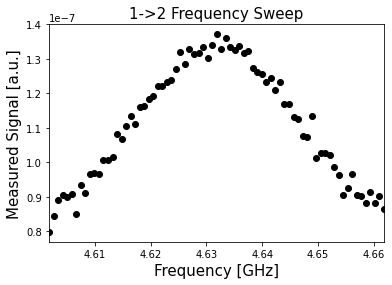

Init params :  [4.631014518652197, 0.014594594594594668, 5.730756500000001e-08, 7.9849855e-08]
The frequency-signal plot of frequency sweep for 1->2 transition.


/home/tharrma/research_qiskit/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


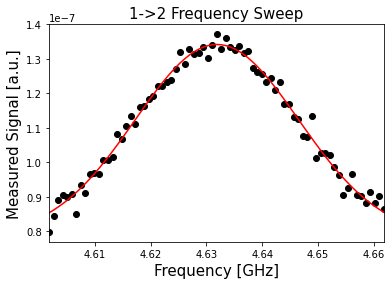

The calibrated frequency for the 1->2 transition                     is 4631888079.23603.


/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Executing the rabi oscillation job for 1->2 transition.
Job Id :  60b502ee32703c0b741a13d1
The amplitude-signal plot of rabi oscillation for 1->2 transition.


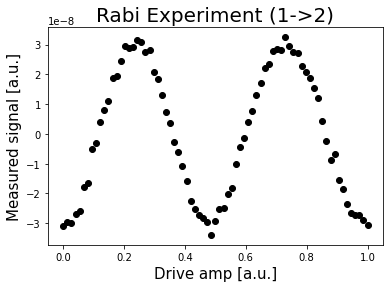

Init params for 01 amp :  [3.321138750000001e-08, 7.235073091130482e-24, 0.5, -1.5707963267948966]
The amplitude-signal plot of rabi oscillation for 1->2 transition.


/home/tharrma/research_qiskit/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


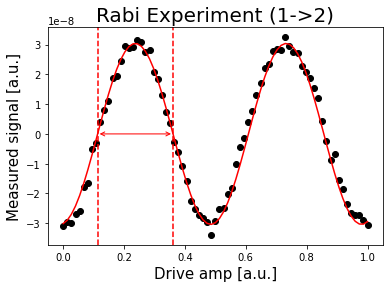

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Job Id :  60b5032c7ff6052865f0214b
The discriminator plot for 0-1-2 discrimination.
The accuracy score of the discriminator is:  0.7688802083333334


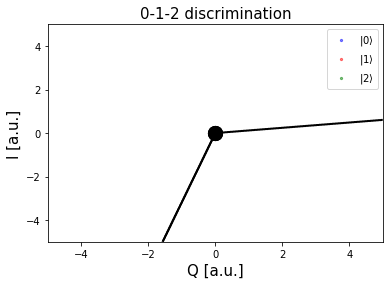

In [175]:
output_list = newcalobject.calibrate_all(verbose, visual)

In [177]:
[new_ground_freq, new_pi_amp_ground, new_excited_freq, new_pi_amp_excited, new_discrim] = output_list

In [179]:
print(new_ground_freq[0])
print(new_pi_amp_ground[0])
print(new_excited_freq[0])
print(new_pi_amp_excited[0])

4969452919.576077
0.17583344067254725
4631888079.23603
0.11321191356753489


In [27]:
back_config = backend.configuration()
back_defaults = backend.defaults()

In [28]:
inst_sched_map = back_defaults.instruction_schedule_map
meas_map_idx = None
for i, measure_group in enumerate(back_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
# The measurement pulse for measuring the qubit of interest.
measure = inst_sched_map.get('measure', qubits=back_config.meas_map[meas_map_idx])

In [29]:
# Should be getting |2> ideally.
sigma = 40
duration = 4*40
chan = DriveChannel(0)

with pulse.build(backend) as test_0:
    pulse.set_frequency(ground_freq, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_ground), chan)
    pulse.set_frequency(excited_freq, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_excited), chan)
test_0 += measure << test_0.duration

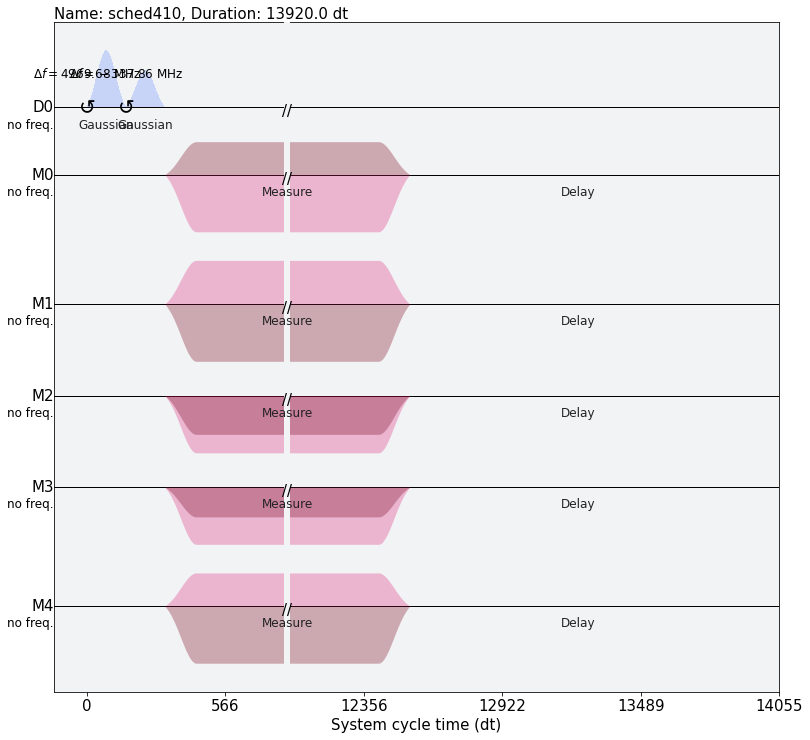

In [30]:
test_0.draw()

In [31]:
test0_job = execute(test_0, backend=backend,
                          meas_level=1, meas_return='single', shots=1024,
                          schedule_los=[{chan: ground_freq}]
                          )
jid_test0 = test0_job.job_id()
print(jid_test0)

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


60b4eebe4a088c29c2c55e0d


In [32]:
test0_job = backend.retrieve_job(jid_test0)

In [33]:
res = get_job_data(test0_job, average=False)

In [34]:
res[0]

array([1.3410259e-07-2.0611660e-07j, 1.8453344e-07-2.1713368e-07j,
       5.3306040e-08-1.9414934e-07j, ..., 1.9213730e-07-1.6109600e-07j,
       1.8182784e-07-1.6345703e-07j, 1.3137174e-07-2.1862052e-07j])

In [35]:
reshaped_res = reshape_complex_vec(res[0])

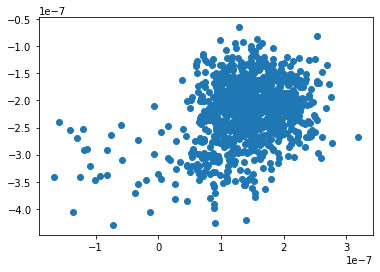

In [36]:
plt.scatter(np.real(res[0]), np.imag(res[0]))
plt.show()

In [37]:
output = discrim.predict(reshaped_res)

In [38]:
arr = [0,0,0]
for i in output:
    if i==0:
        arr[0]+=1
    elif i==1:
        arr[1]+=1
    else:
        arr[2]+=1
print(arr)

[21, 172, 831]


In [39]:
# Performing a 0-1 pi pulse.
# Should be ideally getting |1>
with pulse.build(backend) as test_00:
    pulse.set_frequency(ground_freq, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_ground), chan)
test_00 += measure << test_00.duration

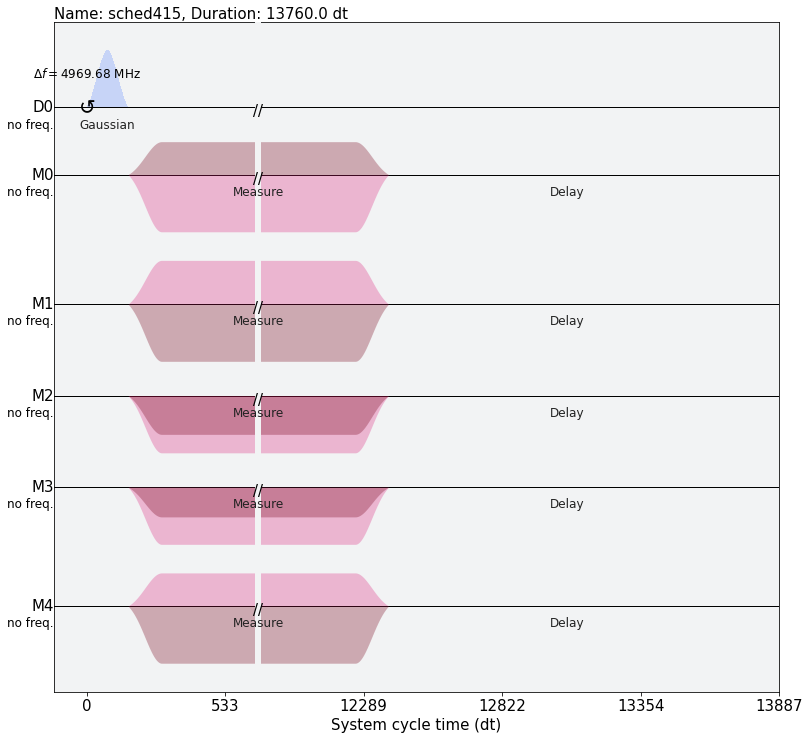

In [40]:
test_00.draw()

In [41]:
test00_job = execute(test_00, backend=backend,
                          meas_level=1, meas_return='single', shots=1024,
                          schedule_los=[{chan: ground_freq}]
                          )
jid_test00 = test00_job.job_id()
print(jid_test00)

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


60b4ef285255f041ec38b4df


In [42]:
test00_job = backend.retrieve_job(jid_test00)

In [43]:
res00 = get_job_data(test00_job, average=False)

In [45]:
res00[0]

array([ 5.9200050e-08-3.2890304e-07j,  1.0680062e-07-3.2275302e-07j,
        8.1846850e-08-3.1458372e-07j, ..., -1.5374531e-07-4.2643428e-07j,
        7.9939850e-08-2.7617688e-07j,  2.0451700e-08-3.4332880e-07j])

In [46]:
reshaped_res00 = reshape_complex_vec(res00[0])

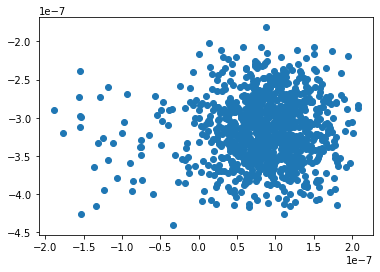

In [47]:
plt.scatter(np.real(res00[0]), np.imag(res00[0]))
plt.show()

In [48]:
output00 = discrim.predict(reshaped_res00)

In [49]:
arr = [0,0,0]
for i in output00:
    if i==0:
        arr[0]+=1
    elif i==1:
        arr[1]+=1
    else:
        arr[2]+=1
print(arr)

[42, 793, 189]


In [50]:
# Performing a H then Z then H gate on 0-1
# Should get |1> ideally.
chan = DriveChannel(0)
with pulse.build(backend) as test_pulse_1:
    # Setting 0-1 frequency for channel and applying H gate
    pulse.set_frequency(ground_freq, chan)
    pulse.shift_phase(-np.pi/2, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_ground/2, name='X(pi/2)'), chan)
    pulse.shift_phase(-np.pi/2, chan)
    
    # Applying a Z pulse
    pulse.shift_phase(np.pi, chan)
    
    # Applying H gate on 0-1
    pulse.shift_phase(-np.pi/2, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_ground/2, name='X(pi/2)'), chan)
    pulse.shift_phase(-np.pi/2, chan)
test_pulse_1 += measure << test_pulse_1.duration

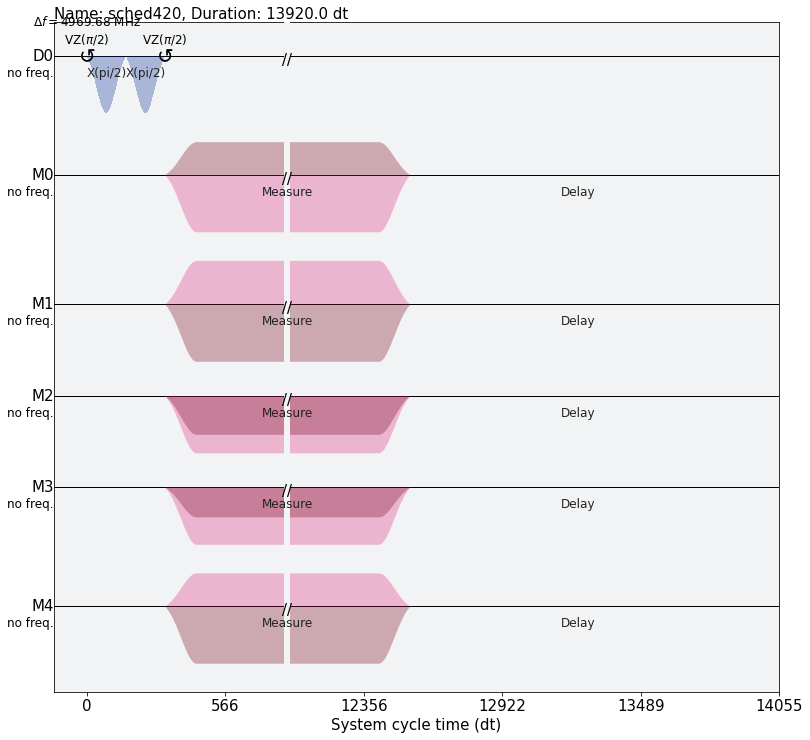

In [51]:
test_pulse_1.draw()

In [52]:
test1_job = execute(test_pulse_1, backend=backend,
                          meas_level=1, meas_return='single', shots=1024,
                          schedule_los=[{chan: ground_freq}]
                          )
jid_test1 = test1_job.job_id()
print(jid_test1)

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


60b4ef58e42d846bf377e20d


In [53]:
test1_job = backend.retrieve_job(jid_test1)

In [54]:
res1 = get_job_data(test1_job, average=False)

In [55]:
reshaped_res1 = reshape_complex_vec(res1[0])

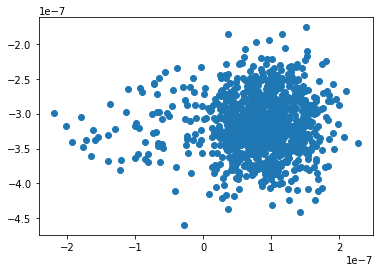

In [56]:
plt.scatter(np.real(res1[0]), np.imag(res1[0]))
plt.show()

In [57]:
output1 = discrim.predict(reshaped_res1)

In [58]:
arr = [0,0,0]
for i in output1:
    if i==0:
        arr[0]+=1
    elif i==1:
        arr[1]+=1
    else:
        arr[2]+=1
print(arr)

[59, 790, 175]


In [59]:
# Performing a H then Z then H gate on 1-2
# Should get |2> ideally.
chan = DriveChannel(0)
with pulse.build(backend) as test_pulse_2:
    # Exciting the qubit to |1> state
    pulse.set_frequency(ground_freq, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_ground, name='X(pi)'), chan)
    
    # Setting 1-2 frequency for channel and applying H gate
    pulse.set_frequency(excited_freq, chan)
    pulse.shift_phase(-np.pi/2, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_excited/2, name='X(pi/2)'), chan)
    pulse.shift_phase(-np.pi/2, chan)
    
    # Applying a Z pulse
    pulse.shift_phase(np.pi, chan)
    
    # Applying H gate on 1-2
    pulse.shift_phase(-np.pi/2, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_excited/2, name='X(pi/2)'), chan)
    pulse.shift_phase(-np.pi/2, chan)
test_pulse_2 += measure << test_pulse_2.duration

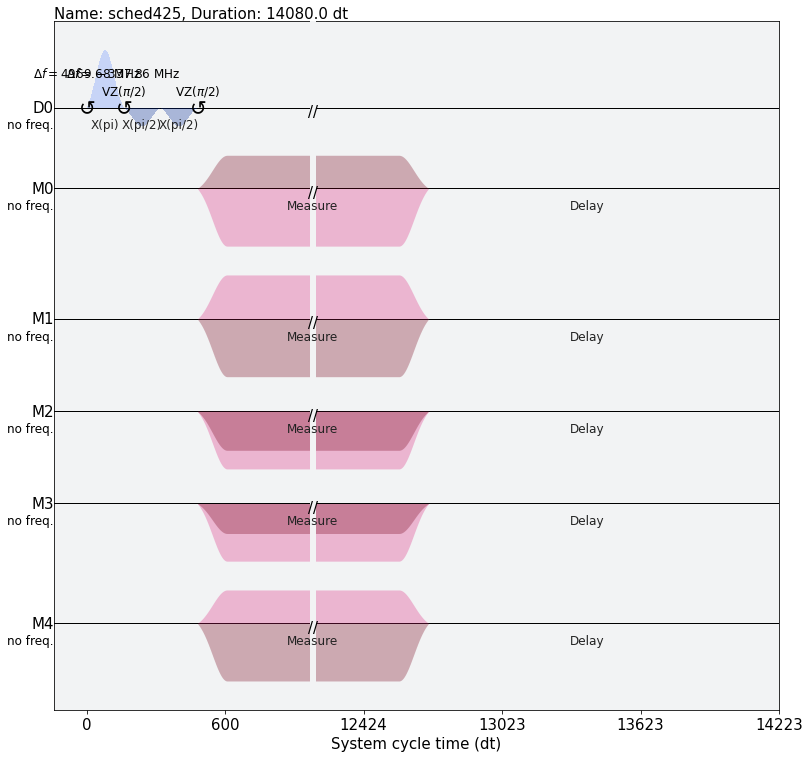

In [60]:
test_pulse_2.draw()

In [61]:
test2_job = execute(test_pulse_2, backend=backend,
                          meas_level=1, meas_return='single', shots=1024,
                          schedule_los=[{chan: ground_freq}]
                          )
jid_test2 = test2_job.job_id()
print(jid_test2)

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


60b4ef79db28f1e602fe74be


In [62]:
test2_job = backend.retrieve_job(jid_test2)

In [63]:
res2 = get_job_data(test2_job, average=False)

In [64]:
reshaped_res2 = reshape_complex_vec(res2[0])

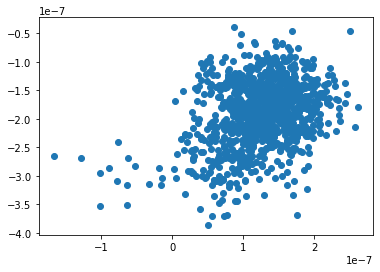

In [65]:
plt.scatter(np.real(res2[0]), np.imag(res2[0]))
plt.show()

In [66]:
output2 = discrim.predict(reshaped_res2)

In [67]:
arr = [0,0,0]
for i in output2:
    if i==0:
        arr[0]+=1
    elif i==1:
        arr[1]+=1
    else:
        arr[2]+=1
print(arr)

[13, 85, 926]


In [68]:
# Performing a H on 0-1, then H on 1-2
# then Z on 1-2 followed by H on 1-2
# Should get |0>/sqrt(2) + |2>/sqrt(2)
chan = DriveChannel(0)
with pulse.build(backend) as test_pulse_3:
    # Setting 0-1 frequency for channel and applying H gate
    pulse.set_frequency(ground_freq, chan)
    pulse.shift_phase(-np.pi/2, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_ground/2, name='X(pi/2)'), chan)
    pulse.shift_phase(-np.pi/2, chan)
    
    # Undoing phase appied during 0-1 transitions
    pulse.shift_phase(np.pi, chan)
    
    # Setting 1-2 frequency for channel and applying H gate
    pulse.set_frequency(excited_freq, chan)
    pulse.shift_phase(-np.pi/2, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_excited/2, name='X(pi/2)'), chan)
    pulse.shift_phase(-np.pi/2, chan)
    
    # Applying a Z pulse
    pulse.shift_phase(np.pi, chan)
    
    # Applying H gate on 1-2
    pulse.shift_phase(-np.pi/2, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_excited/2, name='X(pi/2)'), chan)
    pulse.shift_phase(-np.pi/2, chan)
test_pulse_3 += measure << test_pulse_3.duration

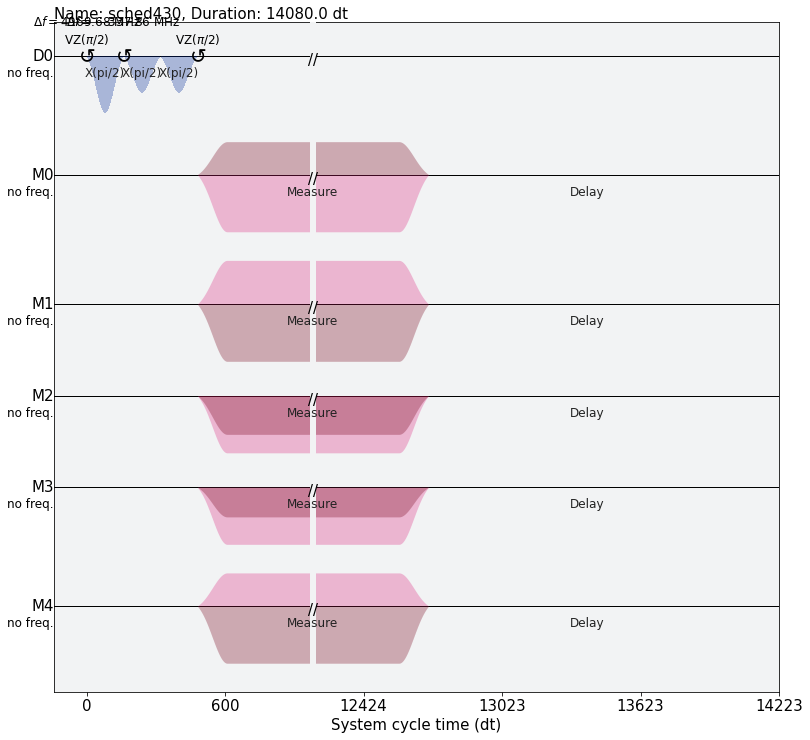

In [69]:
test_pulse_3.draw()

In [70]:
test3_job = execute(test_pulse_3, backend=backend,
                          meas_level=1, meas_return='single', shots=1024,
                          schedule_los=[{chan: ground_freq}]
                          )
jid_test3 = test3_job.job_id()
print(jid_test3)

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


60b4ef9d5255f04a6338b4e4


In [71]:
test3_job = backend.retrieve_job(jid_test3)

In [72]:
res3 = get_job_data(test3_job, average=False)

In [73]:
reshaped_res3 = reshape_complex_vec(res3[0])

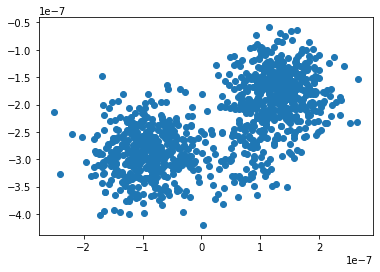

In [74]:
plt.scatter(np.real(res3[0]), np.imag(res3[0]))
plt.show()

In [75]:
output3 = discrim.predict(reshaped_res3)

In [76]:
arr = [0,0,0]
for i in output3:
    if i==0:
        arr[0]+=1
    elif i==1:
        arr[1]+=1
    else:
        arr[2]+=1
print(arr)

[428, 75, 521]


In [77]:
# Performing a H on 1-2
# Should get |1>/sqrt(2) + |2>/sqrt(2) ideally.
chan = DriveChannel(0)
with pulse.build(backend) as test_pulse_4:
    # Exciting the qubit to |1> state
    pulse.set_frequency(ground_freq, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_ground, name='X(pi)'), chan)
    
    # Setting 1-2 frequency for channel and applying H gate
    pulse.set_frequency(excited_freq, chan)
    pulse.shift_phase(-np.pi/2, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_excited/2, name='X(pi/2)'), chan)
    pulse.shift_phase(-np.pi/2, chan)
test_pulse_4 += measure << test_pulse_4.duration

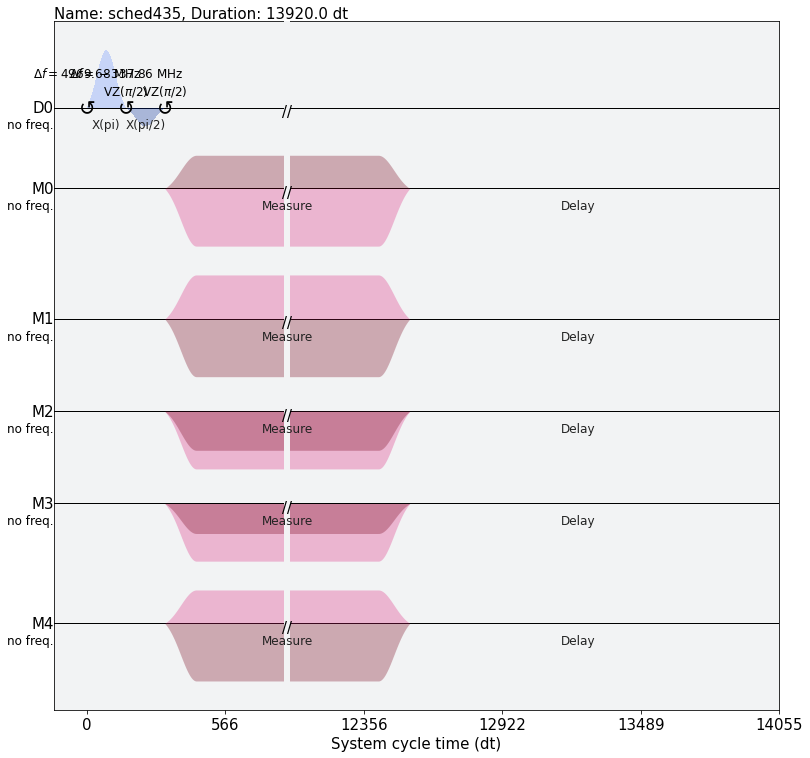

In [78]:
test_pulse_4.draw()

In [79]:
test4_job = execute(test_pulse_4, backend=backend,
                          meas_level=1, meas_return='single', shots=1024,
                          schedule_los=[{chan: ground_freq}]
                          )
jid_test4 = test4_job.job_id()
print(jid_test4)

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


60b4efc77ff6058668f02097


In [80]:
test4_job = backend.retrieve_job(jid_test4)

In [81]:
res4 = get_job_data(test4_job, average=False)

In [82]:
reshaped_res4 = reshape_complex_vec(res4[0])

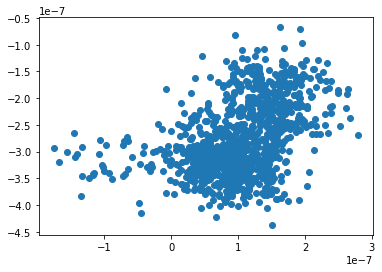

In [83]:
plt.scatter(np.real(res4[0]), np.imag(res4[0]))
plt.show()

In [84]:
output4 = discrim.predict(reshaped_res4)

In [85]:
arr = [0,0,0]
for i in output4:
    if i==0:
        arr[0]+=1
    elif i==1:
        arr[1]+=1
    else:
        arr[2]+=1
print(arr)

[41, 541, 442]


In [86]:
# Performing a H on 0-1
# Should get |0>/sqrt(2) + |1>/sqrt(2) ideally.
chan = DriveChannel(0)
with pulse.build(backend) as test_pulse_5:
    # Setting 0-1 frequency for channel and applying H gate
    pulse.set_frequency(ground_freq, chan)
    pulse.shift_phase(-np.pi/2, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_ground/2, name='X(pi/2)'), chan)
    pulse.shift_phase(-np.pi/2, chan)
test_pulse_5 += measure << test_pulse_5.duration

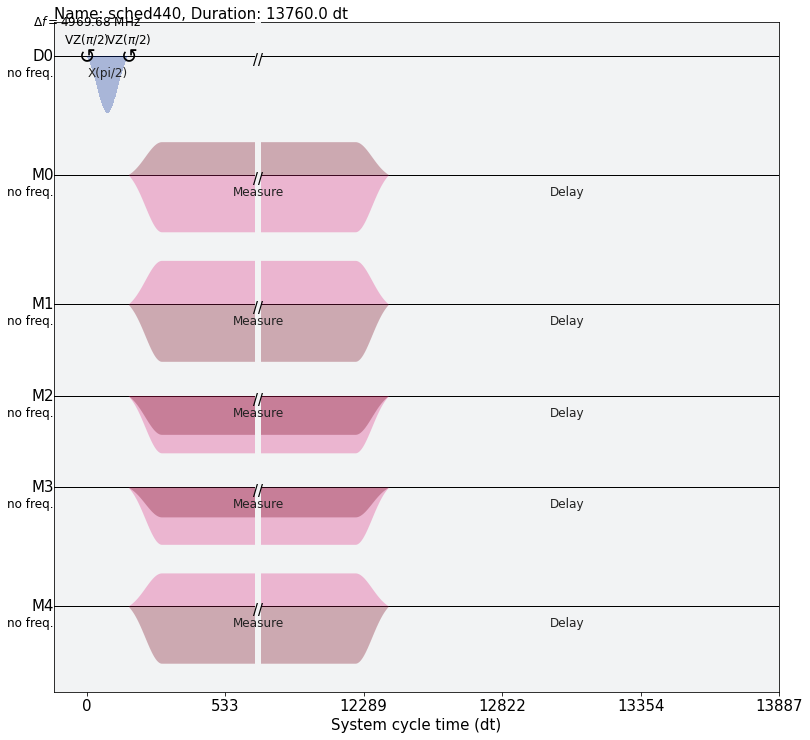

In [87]:
test_pulse_5.draw()

In [88]:
test5_job = execute(test_pulse_5, backend=backend,
                          meas_level=1, meas_return='single', shots=1024,
                          schedule_los=[{chan: ground_freq}]
                          )
jid_test5 = test5_job.job_id()
print(jid_test5)

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


60b4eff0e42d84a83477e213


In [89]:
test5_job = backend.retrieve_job(jid_test5)

In [90]:
res5 = get_job_data(test5_job, average=False)

In [91]:
reshaped_res5 = reshape_complex_vec(res5[0])

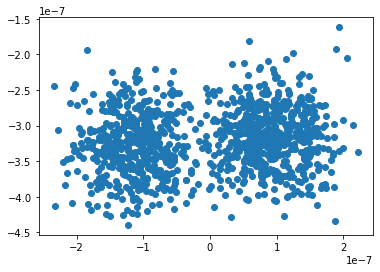

In [92]:
plt.scatter(np.real(res5[0]), np.imag(res5[0]))
plt.show()

In [93]:
output5 = discrim.predict(reshaped_res5)

In [94]:
arr = [0,0,0]
for i in output5:
    if i==0:
        arr[0]+=1
    elif i==1:
        arr[1]+=1
    else:
        arr[2]+=1
print(arr)

[459, 466, 99]


In [95]:
# Performing a X on 0-1
# Should get |1> ideally.
chan = DriveChannel(0)
with pulse.build(backend) as test_pulse_6:
    # Setting 0-1 frequency for channel and applying X gate
    pulse.set_frequency(ground_freq, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_ground, name='X(pi)'), chan)
test_pulse_6 += measure << test_pulse_6.duration

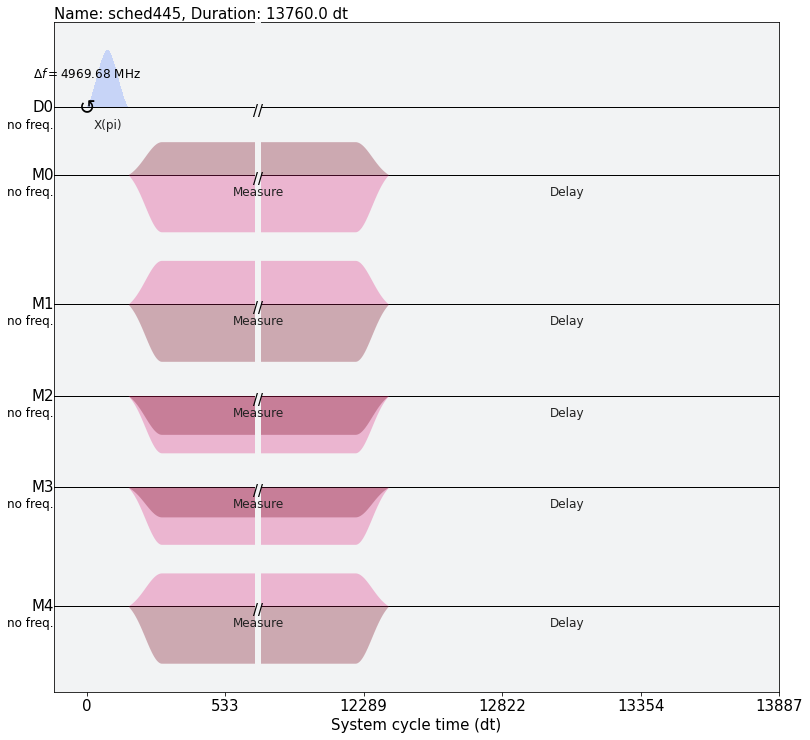

In [96]:
test_pulse_6.draw()

In [97]:
test6_job = execute(test_pulse_6, backend=backend,
                          meas_level=1, meas_return='single', shots=1024,
                          schedule_los=[{chan: ground_freq}]
                          )
jid_test6 = test6_job.job_id()
print(jid_test6)

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


60b4f0167ff605f6f9f02099


In [98]:
test6_job = backend.retrieve_job(jid_test6)

In [99]:
res6 = get_job_data(test6_job, average=False)

In [100]:
reshaped_res6 = reshape_complex_vec(res6[0])

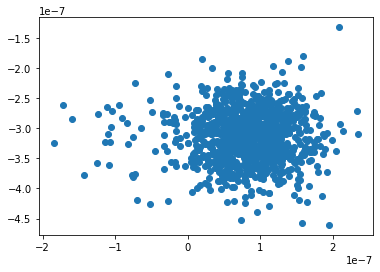

In [101]:
plt.scatter(np.real(res6[0]), np.imag(res6[0]))
plt.show()

In [102]:
output6 = discrim.predict(reshaped_res6)

In [103]:
arr = [0,0,0]
for i in output6:
    if i==0:
        arr[0]+=1
    elif i==1:
        arr[1]+=1
    else:
        arr[2]+=1
print(arr)

[43, 784, 197]


In [104]:
# Performing a X on 1-2
# Should get |2> ideally.
chan = DriveChannel(0)
with pulse.build(backend) as test_pulse_7:
    # Setting 0-1 frequency for channel and applying 0-1 pi pulse
    pulse.set_frequency(ground_freq, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_ground, name='X(pi)'), chan)
    
    # Setting 1-2 frequency for channel and applying 1-2 pi pulse
    pulse.set_frequency(excited_freq, chan)
    pulse.play(Gaussian(duration=duration, sigma=sigma, amp=pi_amp_excited, name='X(pi)'), chan)
test_pulse_7 += measure << test_pulse_7.duration

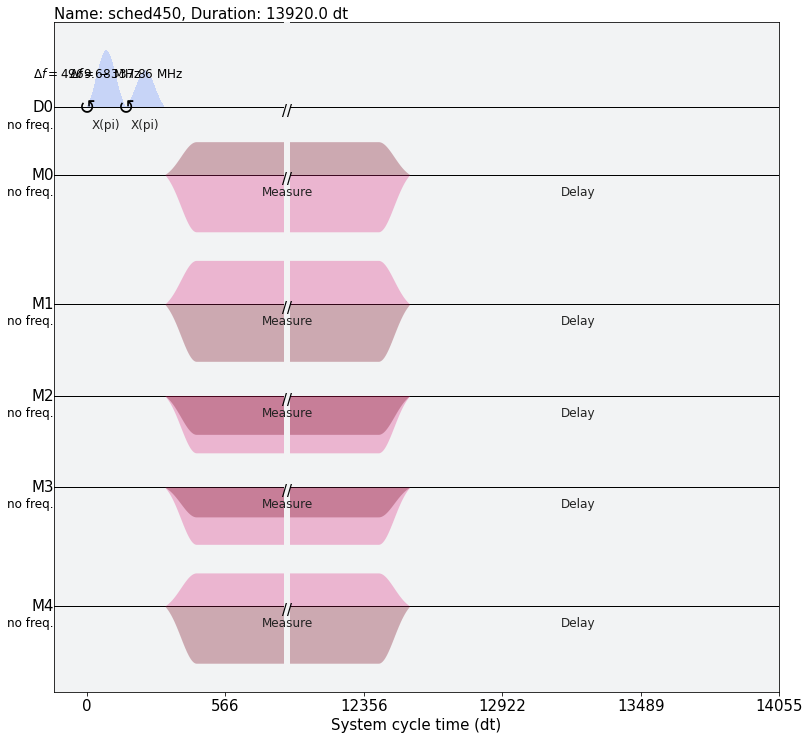

In [105]:
test_pulse_7.draw()

In [106]:
test7_job = execute(test_pulse_7, backend=backend,
                          meas_level=1, meas_return='single', shots=1024,
                          schedule_los=[{chan: ground_freq}]
                          )
jid_test7 = test7_job.job_id()
print(jid_test7)

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


60b4f0455255f0621b38b4ea


In [107]:
test7_job = backend.retrieve_job(jid_test7)

In [108]:
res7 = get_job_data(test7_job, average=False)

In [109]:
reshaped_res7 = reshape_complex_vec(res7[0])

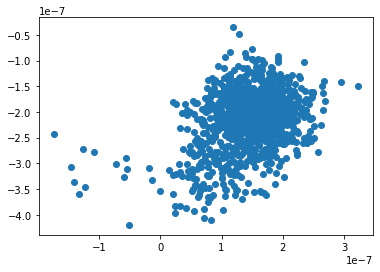

In [110]:
plt.scatter(np.real(res7[0]), np.imag(res7[0]))
plt.show()

In [111]:
output7 = discrim.predict(reshaped_res7)

In [112]:
arr = [0,0,0]
for i in output7:
    if i==0:
        arr[0]+=1
    elif i==1:
        arr[1]+=1
    else:
        arr[2]+=1
print(arr)

[13, 171, 840]


In [130]:
back_config = backend.configuration()

In [131]:
print("Supported kernels: ", back_config.meas_kernels)
print("Supported discriminators: ", back_config.discriminators)

Supported kernels:  ['hw_qmfk']
Supported discriminators:  ['quadratic_discriminator', 'linear_discriminator', 'hw_qmfk']


In [135]:
qc = QuantumCircuit(2)
qc.cx(0,1)
with pulse.build(backend) as cnot_pulse:
    pulse.call(qc)
cnot_pulse += measure << cnot_pulse.duration

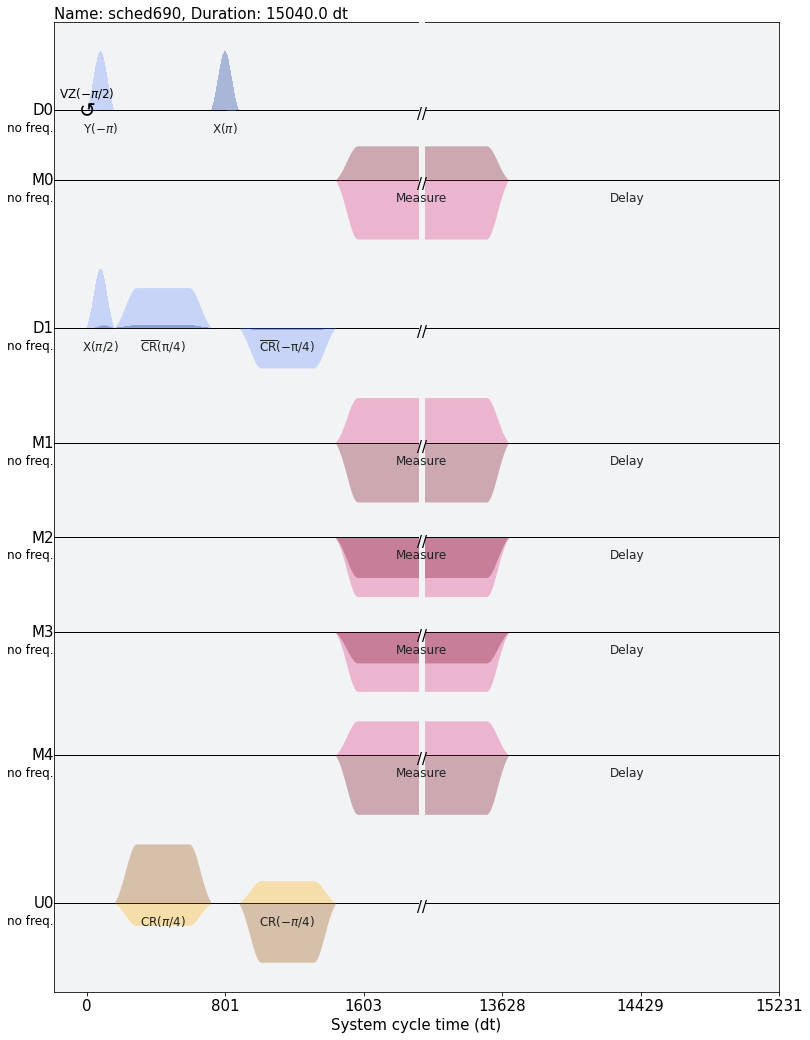

In [136]:
cnot_pulse.draw()

In [137]:
cnot_job = execute(cnot_pulse, backend=backend,
                          meas_level=1, meas_return='single', shots=1024,
                          schedule_los=[{chan: ground_freq}]
                          )
jid_cnot = cnot_job.job_id()
print(jid_cnot)

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


60b4f86d9f32f918eb0bb422


In [138]:
cnot_job = backend.retrieve_job(jid_cnot)

In [152]:
cnot_job.result().to_dict()

{'backend_name': 'ibmq_rome',
 'backend_version': '1.3.22',
 'qobj_id': '029d13b8-87b7-4f38-93f7-4c3b78ea84af',
 'job_id': '60b4f86d9f32f918eb0bb422',
 'success': True,
 'results': [{'shots': 1024,
   'success': True,
   'data': {'memory': [[[-12230327.0, -33092524.0],
      [-20072164.0, -80347200.0],
      [-9862326.0, -50824592.0],
      [-15758018.0, -44909252.0],
      [-10243286.0, -36782216.0]],
     [[-5023671.0, -27038264.0],
      [-22316964.0, -89487184.0],
      [-17377376.0, -65279224.0],
      [-15532824.0, -32668100.0],
      [-7573275.0, -38472868.0]],
     [[-6792599.0, -31254562.0],
      [-6518013.0, -73462320.0],
      [-10461457.0, -53671608.0],
      [-6285628.0, -39382376.0],
      [-22458022.0, -39755016.0]],
     [[-12088754.0, -33482712.0],
      [-24613322.0, -65431128.0],
      [-17562588.0, -51207192.0],
      [-29682182.0, -42935152.0],
      [-5841574.0, -34653912.0]],
     [[-5943034.0, -33033286.0],
      [-18296324.0, -69372560.0],
      [-24160010.0, 

In [139]:
cnot_res = get_job_data(cnot_job, average=False)

In [140]:
reshaped_cnot_res = reshape_complex_vec(cnot_res[0])

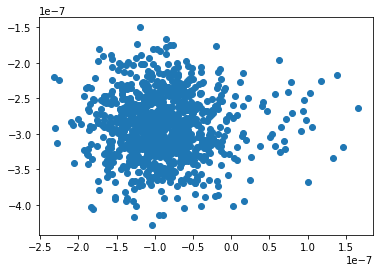

In [141]:
plt.scatter(np.real(cnot_res[0]), np.imag(cnot_res[0]))
plt.show()

In [142]:
cnot_output = discrim.predict(reshaped_cnot_res)

In [143]:
arr = [0,0,0]
for i in cnot_output:
    if i==0:
        arr[0]+=1
    elif i==1:
        arr[1]+=1
    else:
        arr[2]+=1
print(arr)

[932, 44, 48]


In [144]:
qc = QuantumCircuit(1)
qc.y(0)
with pulse.build(backend) as ypulse:
    pulse.call(qc)
ypulse += measure << ypulse.duration

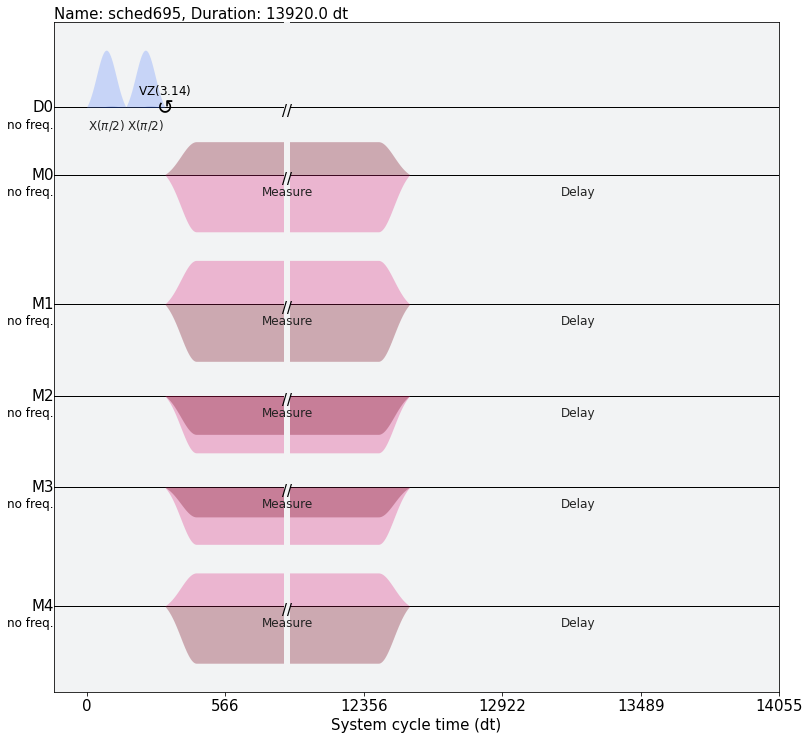

In [145]:
ypulse.draw()